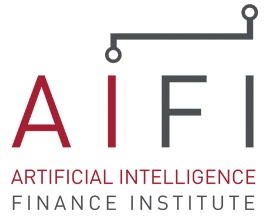


# Bootcamp - Python and Coding - Deep Learning

## Open notebook in:
| Colab                                 |  Gradient                                                                                                                                         |
|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Nicolepcx/Transformers-in-Action/blob/main/CH07/ch07_DPO.ipynb)                                              | [![Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/Nicolepcx/Transformers-in-Action/blob/main/CH07/ch07_DPO.ipynb)|             

In [ ]:
# Clone repo, if it's not already cloned, to be sure all runs smoothly
# on Colab, Kaggle or Paperspace
import os

if not os.path.isdir('Transformers-in-Action'):
    !git clone https://github.com/Nicolepcx/Transformers-in-Action.git
else:
    print('Repository already exists. Skipping clone.')


current_path = %pwd
if '/Transformers-in-Action' in current_path:
    new_path = current_path + '/utils'
else:
    new_path = current_path + '/Transformers-in-Action/utils'
%cd $new_path


Cloning into 'Transformers-in-Action'...
remote: Enumerating objects: 289, done.
remote: Total 289 (delta 0), reused 0 (delta 0), pack-reused 289
Receiving objects: 100% (289/289), 2.45 MiB | 29.47 MiB/s, done.
Resolving deltas: 100% (149/149), done.
/content/Transformers-in-Action/utils


# About this notebook


In this notebook we continue from notebook `14_SFT_LLM.ipynb`to train the model with DPO, here in this notebook, we build on top of this step. 

#Install requirements

In [ ]:
from requirements import *

In [ ]:
install_base_packages()
install_required_packages_ch07()

Installing base requirements...

✅ transformers==4.26.1 installation completed successfully!

✅ datasets==2.10.1 installation completed successfully!

Installing chapter 7 requirements...

✅ accelerate==0.26.1 installation completed successfully!

✅ wandb installation completed successfully!

✅ peft==0.7.1 installation completed successfully!

✅ safetensors==0.4.1 installation completed successfully!

✅ trl==0.7.10 installation completed successfully!

✅ tree-of-thoughts-llm==0.1.0 installation completed successfully!



In [ ]:
%%capture
import torch

# Function to determine the appropriate Unsloth installation based on CUDA major version
def install_unsloth():
    major_version = torch.cuda.get_device_capability()[0]  # Get the major version
    if major_version >= 8:
        # For new GPUs like Ampere, Hopper GPUs (RTX 30xx, RTX 40xx, A100, H100, L40)
        !pip install "unsloth[colab_ampere] @ git+https://github.com/unslothai/unsloth.git"
    else:
        # For older GPUs (V100, Tesla T4, RTX 20xx)
        !pip install "unsloth[colab] @ git+https://github.com/unslothai/unsloth.git"

# Install Unsloth based on the GPU's CUDA major version
install_unsloth()


In [ ]:
!pip install -U transformers -q

# Imports

In [ ]:
import wandb
from unsloth import FastLanguageModel

import os
import re
import pprint
import textwrap
from typing import List, Literal, Optional

from datasets import load_dataset, concatenate_datasets, DatasetDict
from transformers import TrainingArguments
from trl import DPOTrainer

# We have to patch the DPO Trainer
from unsloth import PatchDPOTrainer
PatchDPOTrainer()

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:

model, model_tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/zephyr-sft-bnb-4bit",
    max_seq_length = 4096,
    dtype = None, # Auto dectect type
    load_in_4bit = True # Use 4bit quantization to reduce memory usage.
)


Unsloth: Your transformers version of 4.36.2 does not support native 4bit loading.
The minimum required version is 4.37.
Try `pip install "git+https://github.com/huggingface/transformers.git"`
to obtain the latest transformers build, then restart this session.
For now, we shall load `unsloth/zephyr-sft` instead (still 4bit, just slower downloading).
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

==((====))==  Unsloth: Fast Mistral patching release 2024.1
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB
O^O/ \_/ \    CUDA capability = 7.5. Xformers = 0.0.22.post7. FA = False.
\        /    Pytorch version: 2.1.0+cu121. CUDA Toolkit = 12.1
 "-____-"     bfloat16 = FALSE. Platform = Linux



model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

In [ ]:

DEFAULT_CHAT_TEMPLATE = "{% for message in messages %}\n{% if message['role'] == 'user' %}\n{{ '\n' + message['content'] + eos_token }}\n{% elif message['role'] == 'system' %}\n{{ '\n' + message['content'] + eos_token }}\n{% elif message['role'] == 'assistant' %}\n{{ '\n'  + message['content'] + eos_token }}\n{% endif %}\n{% if loop.last and add_generation_prompt %}\n{{ '' }}\n{% endif %}\n{% endfor %}"

def apply_chat_template(example, tokenizer, assistant_prefix="\n"):
    def _strip_prefix(s, pattern):
        return re.sub(f"^{re.escape(pattern)}", "", s)

    def _concatenate_messages(messages):
        return ' '.join(msg['content'] for msg in messages)

    if all(key in example for key in ('chosen', 'rejected')):
        # Process 'chosen' field
        if isinstance(example['chosen'], list):
            example['chosen'] = _strip_prefix(_concatenate_messages(example['chosen'][1:]), assistant_prefix)

        # Process 'rejected' field
        if isinstance(example['rejected'], list):
            example['rejected'] = _strip_prefix(_concatenate_messages(example['rejected'][1:]), assistant_prefix)

        # Process 'prompt' field, if it's a list of messages
        if 'prompt' in example and isinstance(example['prompt'], list):
            example['prompt'] = _strip_prefix(_concatenate_messages(example['prompt']), assistant_prefix)

    return example


def get_sampled_datasets(dataset_name, splits, fraction, shuffle=True):
    """
    Loads and samples a fraction of the specified dataset splits.

    Args:
        dataset_name (str): The name of the dataset to load.
        splits (List[str]): The specific splits of the dataset to load.
        fraction (float): The fraction of the dataset to sample.
        shuffle (bool): Whether to shuffle the dataset.

    Returns:
        DatasetDict: A dictionary containing the sampled datasets.
    """
    raw_datasets = DatasetDict()
    for split in splits:
        dataset = load_dataset(dataset_name, split=split)
        if shuffle:
            dataset = dataset.shuffle(seed=42)
        sampled_dataset = dataset.select(range(int(fraction * len(dataset))))
        raw_datasets[split] = sampled_dataset
    return raw_datasets


def format_dataset_for_dpo(dataset, tokenizer):
    formatted_dataset = dataset.map(
        lambda example: apply_chat_template(example, tokenizer),
        remove_columns=[col for col in dataset.column_names if col not in ['chosen', 'rejected', 'prompt']],
        desc="Formatting dataset for DPO",
    )
    return formatted_dataset



dataset_name = "HuggingFaceH4/ultrafeedback_binarized"
splits = ["train_prefs", "test_prefs"] # We only use the preference modelling (prefs) splits of the dataset
fraction = 0.1  # The fraction of the dataset to sample
tokenizer = model_tokenizer

# Get sampled datasets
raw_datasets = get_sampled_datasets(dataset_name, splits, fraction)

# Format datasets for DPO
formatted_datasets = DatasetDict()
for split in raw_datasets.keys():
    formatted_datasets[split] = format_dataset_for_dpo(raw_datasets[split], tokenizer)

# Prepare the datasets for training
def prepare_dataset_for_training(dataset):
    # Keep only the necessary columns and drop the rest
    necessary_columns = ['chosen', 'rejected', 'prompt']
    return dataset.remove_columns([col for col in dataset.column_names if col not in necessary_columns])

for split in formatted_datasets.keys():
    formatted_datasets[split] = prepare_dataset_for_training(formatted_datasets[split])

print("Formatted datasets ready for DPO.")


Extracting data files:   0%|          | 0/6 [00:00<?, ?it/s]

Generating train_gen split:   0%|          | 0/61135 [00:00<?, ? examples/s]

Generating test_sft split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating train_sft split:   0%|          | 0/61135 [00:00<?, ? examples/s]

Generating test_prefs split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test_gen split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating train_prefs split:   0%|          | 0/61135 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/HuggingFaceH4___parquet/HuggingFaceH4--ultrafeedback_binarized-3d6b85969d759989/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


Formatting dataset for DPO:   0%|          | 0/6113 [00:00<?, ? examples/s]

Formatting dataset for DPO:   0%|          | 0/200 [00:00<?, ? examples/s]

Formatted datasets ready for DPO.


<a name="Data"></a>
### Data Prep
We use the [Ultra Feedback dataset](https://huggingface.co/datasets/HuggingFaceH4/ultrafeedback_binarized), and sample 0.5% of it to speed things up. You can sample the full dataset for a full run.

Print the dataset

In [ ]:
# Map the dataset and transform the fields
transformed_datasets = raw_datasets.map(
    lambda example: apply_chat_template(example, tokenizer),
    remove_columns=[col for col in raw_datasets["train_prefs"].column_names if col not in ['chosen', 'rejected', 'prompt']],
    desc="Formatting prompt template",
)

Formatting prompt template:   0%|          | 0/6113 [00:00<?, ? examples/s]

Formatting prompt template:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
print(raw_datasets["train_prefs"])
print(raw_datasets["test_prefs"])

Dataset({
    features: ['prompt', 'prompt_id', 'chosen', 'rejected', 'messages', 'score_chosen', 'score_rejected'],
    num_rows: 6113
})
Dataset({
    features: ['prompt', 'prompt_id', 'chosen', 'rejected', 'messages', 'score_chosen', 'score_rejected'],
    num_rows: 200
})


In [ ]:
transformed_datasets

DatasetDict({
    train_prefs: Dataset({
        features: ['prompt', 'chosen', 'rejected'],
        num_rows: 6113
    })
    test_prefs: Dataset({
        features: ['prompt', 'chosen', 'rejected'],
        num_rows: 200
    })
})

In [ ]:
#@title Print out an example
row = transformed_datasets["train_prefs"][1]
print("Prompt: ")
print("===" *40, "\n")
pprint.pprint(row["prompt"])
print("Chosen: ")
print("\n","===" *40,"\n")
pprint.pprint(row["chosen"])
print("Rejected: ")
print("\n","===" *40,"\n")
pprint.pprint(row["rejected"])

Prompt: 

('In this task, you are given a sentence in Persian, and your task is to '
 'translate it into English.\n'
 'Example: جناب گرانت خیلی دلش می\u200cخواست روز یکشنبه بعد از آن همه خستگی '
 'روزانه بنشیند و بوقلمون را بخورد.\n'
 'Example solution: because I know how much more Dr. Grant would enjoy it on '
 'Sunday after the fatigues of the day,\n'
 'Example explanation: This is a good example. The above sentence is correctly '
 'translated from Persian to English.\n'
 '\n'
 'Problem: خرمگس عادت کرده بود که جان خود را به خطر اندازد،\n')
Chosen: 


('Translation: The mongoose had become accustomed to putting its life in '
 'danger.\n'
 '\n'
 'Explanation: In this sentence, the subject is "خرمگس" (mongoose), and it '
 'talks about its habit of taking risks with its life. The translation '
 'accurately captures the meaning of the Persian sentence and is engaging, '
 "sparking curiosity about the mongoose's adventures and why it endangers "
 'itself.')
Rejected: 


("Sure, I'm here to

We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [ ]:
#@title Load model
model = FastLanguageModel.get_peft_model(
    model,
    r = 64, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 64,
    lora_dropout = 0, # Currently only supports dropout = 0
    bias = "none",    # Currently only supports bias = "none"
    use_gradient_checkpointing = True,
    random_state = 42,
    max_seq_length = 4096,
)

Unsloth 2024.1 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


# Train the model

In [ ]:
#@title Training Arguments and DPOTrainer init
training_args = TrainingArguments(
                per_device_train_batch_size = 2,
                gradient_accumulation_steps = 4,
                warmup_ratio = 0.1,
                num_train_epochs = 2,
                learning_rate = 5e-6,
                fp16 = not torch.cuda.is_bf16_supported(),
                bf16 = torch.cuda.is_bf16_supported(),
                logging_steps = 1,
                report_to = "wandb",
                optim = "adamw_8bit",
                weight_decay = 0.0,
                lr_scheduler_type = "cosine",
                seed = 42,
                output_dir = "outputs",
)


dpo_trainer = DPOTrainer(
    model=model,
    ref_model=None,  # Or your actual reference model
    args=training_args,
    beta=0.1,
    train_dataset=transformed_datasets["train_prefs"],
    eval_dataset=transformed_datasets["test_prefs"],
    tokenizer=tokenizer,
    max_length=1024,
    max_prompt_length=512,
)

# Training process
dpo_trainer.train()


/usr/local/lib/python3.10/dist-packages/trl/trainer/dpo_trainer.py:314: UserWarning: When using DPODataCollatorWithPadding, you should set `remove_unused_columns=False` in your TrainingArguments we have set it for you, but you should do it yourself in the future.
  warnings.warn(


Map:   0%|          | 0/6113 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (4097 > 4096). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

wandb: Currently logged in as: nicolepcx. Use `wandb login --relogin` to force relogin


Unsloth: `use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,rewards / chosen,rewards / rejected,rewards / accuracies,rewards / margins,logps / rejected,logps / chosen,logits / rejected,logits / chosen
1,0.693100,0.000000,0.000000,0.000000,0.000000,-320.533752,-475.616608,-2.869827,-2.917157
2,0.693100,0.000000,0.000000,0.000000,0.000000,-203.898987,-186.757690,-2.735156,-2.730834
3,0.693100,0.000000,0.000000,0.000000,0.000000,-267.876770,-223.539856,-2.752163,-2.623283
4,0.694300,-0.002890,-0.000558,0.375000,-0.002332,-233.376038,-330.111877,-2.689517,-2.883741
5,0.693900,-0.001325,0.000136,0.375000,-0.001461,-318.866241,-331.415771,-2.867082,-2.857538
6,0.692500,-0.000383,-0.001712,0.625000,0.001329,-188.202209,-189.997986,-2.848657,-2.869583
7,0.693400,-0.001622,-0.001216,0.500000,-0.000406,-278.873474,-265.484863,-2.666931,-2.583364
8,0.691000,0.002369,-0.001964,0.750000,0.004334,-304.227966,-225.025024,-2.842738,-2.716714
9,0.691100,0.001850,-0.002201,0.500000,0.004051,-287.426483,-406.545105,-2.878016,-2.831541
10,0.694300,0.000083,0.002429,0.375000,-0.002345,-191.755127,-235.756042,-2.880060,-2.932044


Step,Training Loss,rewards / chosen,rewards / rejected,rewards / accuracies,rewards / margins,logps / rejected,logps / chosen,logits / rejected,logits / chosen
1,0.693100,0.000000,0.000000,0.000000,0.000000,-320.533752,-475.616608,-2.869827,-2.917157
2,0.693100,0.000000,0.000000,0.000000,0.000000,-203.898987,-186.757690,-2.735156,-2.730834
3,0.693100,0.000000,0.000000,0.000000,0.000000,-267.876770,-223.539856,-2.752163,-2.623283
4,0.694300,-0.002890,-0.000558,0.375000,-0.002332,-233.376038,-330.111877,-2.689517,-2.883741
5,0.693900,-0.001325,0.000136,0.375000,-0.001461,-318.866241,-331.415771,-2.867082,-2.857538
6,0.692500,-0.000383,-0.001712,0.625000,0.001329,-188.202209,-189.997986,-2.848657,-2.869583
7,0.693400,-0.001622,-0.001216,0.500000,-0.000406,-278.873474,-265.484863,-2.666931,-2.583364
8,0.691000,0.002369,-0.001964,0.750000,0.004334,-304.227966,-225.025024,-2.842738,-2.716714
9,0.691100,0.001850,-0.002201,0.500000,0.004051,-287.426483,-406.545105,-2.878016,-2.831541
10,0.694300,0.000083,0.002429,0.375000,-0.002345,-191.755127,-235.756042,-2.880060,-2.932044


KeyboardInterrupt: 

In [ ]:
#@title Save trained model
model.save_pretrained("lora_dpo_model")

# Generate prompt outputs with DPO model

In [ ]:
#@title Prepare dataset for prompt
alpaca_template = """Write a response that completes the task from below, following the instruction.

### Instruction:
{}

### Input:
{}

### Response:
{}"""


In [ ]:
#@title Prepare the data with tokenizer
prompt = model_tokenizer(
    [
        alpaca_template.format(
            "What is the iconic symbol of freedom at the US east coast?",  # instruction
            "",  # input
            "",  # output
        )
    ] * 1, return_tensors="pt").to("cuda")

# Model's generation settings
generation_parameters = {
    "max_new_tokens": 256,  # Maximum number of new tokens to generate
    "use_cache": True  # Whether to use past key values for attention
}

# Generate outputs using the model and the specified generation parameters
outputs = model.generate(**prompt, **generation_parameters)

# Decode the generated outputs
decoded_outputs = model_tokenizer.batch_decode(outputs, skip_special_tokens=True)


In [ ]:
#@title Get outputs from model
# Define the maximum line width for the print function
max_line_width = 80

# Cleaning and formatting the output
cleaned_outputs = []
for output in decoded_outputs:
    # Splitting the text into sections based on '\n'
    sections = output.split('\n')

    # Find the index where the actual content starts (skipping the first line)
    start_idx = 1 if len(sections) > 1 and sections[0].startswith("Write a response") else 0

    # Rejoin the relevant sections
    relevant_content = "\n".join(sections[start_idx:])

    # Remove unwanted characters and replace '###' with '\n'
    relevant_content = relevant_content.replace("###", "\n").replace("[", "").replace("]", "").replace("'", "")

    # Split the text into sections based on '\n'
    sections = relevant_content.split('\n')

    # Wrap text for each section and join them back with double newlines
    wrapped_sections = [textwrap.fill(section, width=max_line_width) for section in sections]
    formatted_output = '\n'.join(wrapped_sections)

    # Add the cleaned and formatted text to the list
    cleaned_outputs.append(formatted_output)

# Print the cleaned and formatted output
for text in cleaned_outputs:
    print(text)